<a href="https://colab.research.google.com/github/clodoaldocodes/CAMERA-APP/blob/main/plantio/deteccao_linha_plantio_hough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

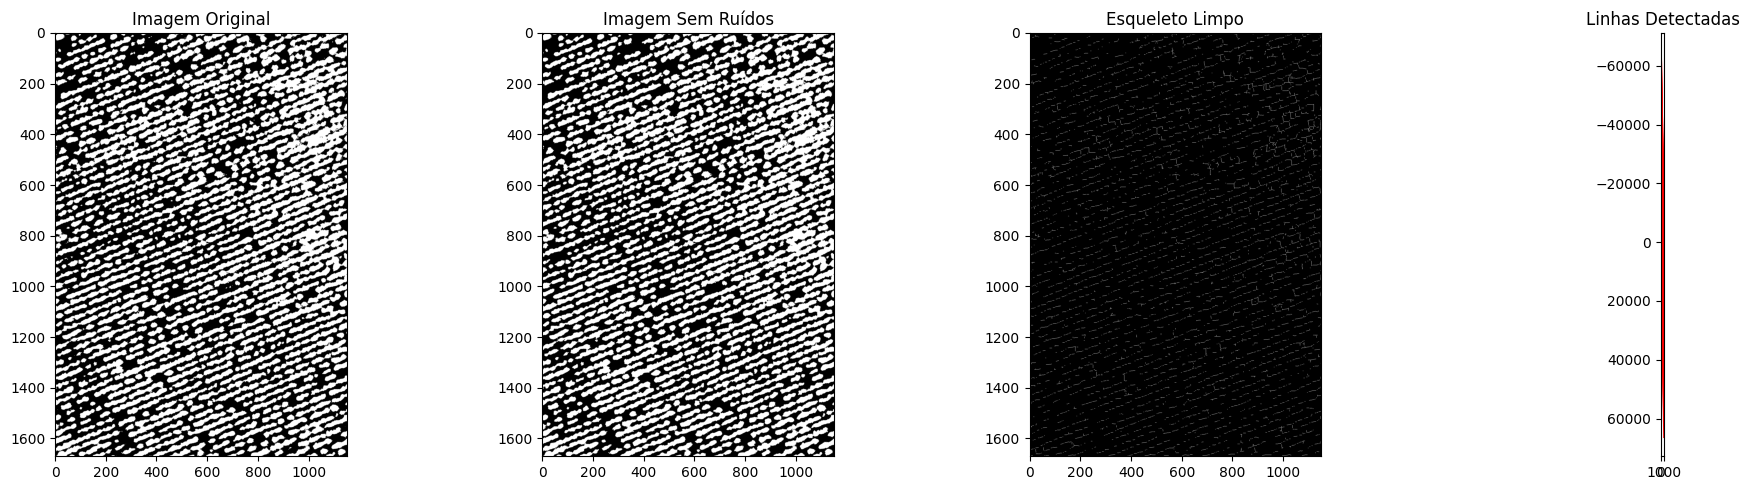

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, transform, filters

# Carregar a imagem
# image = io.imread('/content/drive/Shareddrives/Inspectral Drive/Projetos/CANA/saida_linhas_plantio.tif')
image = io.imread('/content/drive/Shareddrives/Inspectral Drive/Projetos/CANA/resultado_1.tif')


# Converter a imagem para binária (2 -> 1, 1 -> 0)
binary_image = np.where(image == 2, 1, 0)

# Remover pequenos objetos (ajuste o valor de `min_size` conforme necessário)
cleaned_image = morphology.remove_small_objects(binary_image.astype(bool), min_size=50)

# Aplicar filtro Gaussiano para suavização (ajuste o sigma conforme necessário)
smoothed_image = filters.gaussian(cleaned_image, sigma=1)

# Binarizar novamente após suavização (para manter os valores em 0 ou 1)
smoothed_binary_image = smoothed_image > 0.5

# Aplicar esqueletonização
skeleton = morphology.skeletonize(smoothed_binary_image)

# Limpar o esqueleto removendo pequenos ramos (ajuste o valor de `min_size` conforme necessário)
cleaned_skeleton = morphology.remove_small_objects(skeleton, min_size=3)

# Definir o intervalo de ângulos para a Transformada de Hough (230 graus)
angle_range = np.deg2rad(np.arange(178, 180, 1))

# Aplicar transformada de Hough apenas no intervalo de 230 graus
h, theta, d = transform.hough_line(cleaned_skeleton, theta=angle_range)

# Visualizar os resultados
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Imagem Original')
axes[1].imshow(cleaned_image, cmap='gray')
axes[1].set_title('Imagem Sem Ruídos')
axes[2].imshow(cleaned_skeleton, cmap='gray')
axes[2].set_title('Esqueleto Limpo')
axes[3].imshow(image, cmap='gray')

for _, angle, dist in zip(*transform.hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - skeleton.shape[1] * np.cos(angle)) / np.sin(angle)
    axes[3].plot((0, skeleton.shape[1]), (y0, y1), '-r')

axes[3].set_title('Linhas Detectadas')

plt.tight_layout()
plt.show()

# Código que funcionou


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, transform, filters
from skimage.morphology import remove_small_objects
import geopandas as gpd
from shapely.geometry import LineString, mapping

# Carregar a imagem
# image = io.imread('/content/drive/Shareddrives/Inspectral Drive/Projetos/CANA/saida_linhas_plantio.tif')
image = io.imread('/content/drive/Shareddrives/Inspectral Drive/Projetos/CANA/resultado_1.tif')
# Calcular as dimensões da imagem
rows, cols = image.shape[:2]

# # Definir os limites da parte a ser extraída
# row_start = 1
# row_end = rows // 4
# col_start = 1
# col_end = cols // 4

# # Extrair a parte da imagem
# image = image[row_start:row_end, col_start:col_end]

bin_img = np.where(image == 2, 1, 0)

from scipy.ndimage import binary_closing

# Aplicando fechamento
closed_img = binary_closing(bin_img, structure=np.ones((3,1)))

from scipy.ndimage import binary_erosion

# Aplicando erosão
eroded_img = binary_erosion(closed_img, structure=np.ones((3,11)))

from skimage.morphology import skeletonize

# Esqueletizando a imagem
skeleton = skeletonize(eroded_img)
skeleton_cleaned = skeleton #remove_small_objects(skeleton.astype(bool), min_size=3)

from skimage.transform import hough_line, hough_line_peaks

# Realizando a Transformada de Hough
h, theta, d = hough_line(skeleton_cleaned)

# Extraindo os picos (linhas) detectados
peaks = hough_line_peaks(h, theta, d)

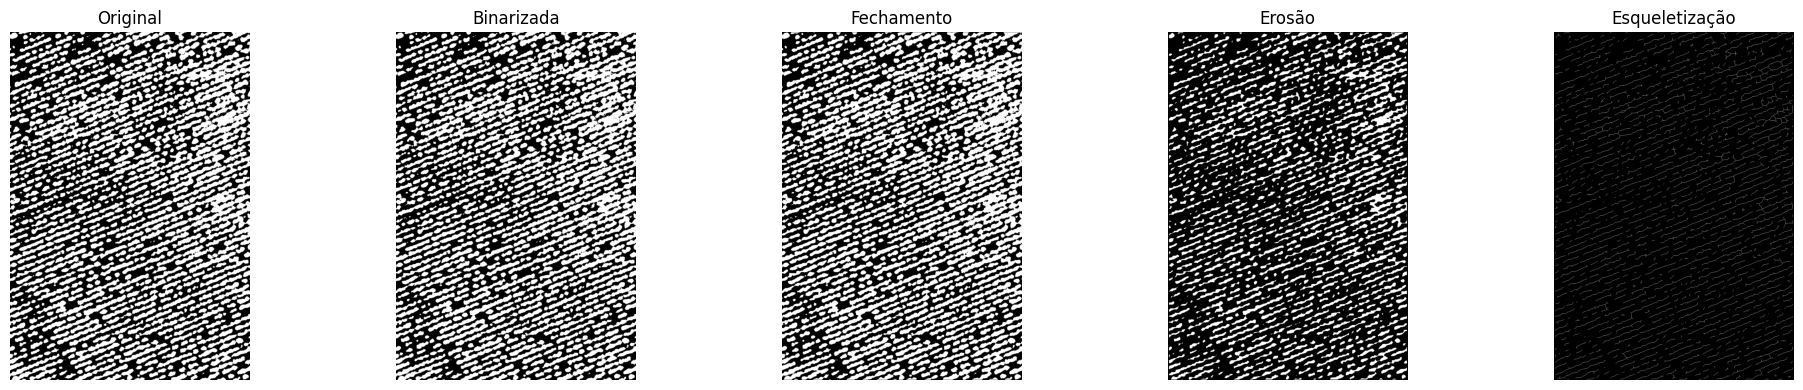

In [ ]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# Função para exibir imagens
def plot_results(original, binarized, closed, eroded, skeleton):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(original, cmap=plt.cm.gray)
    ax[0].set_title("Original")

    ax[1].imshow(binarized, cmap=plt.cm.gray)
    ax[1].set_title("Binarizada")

    ax[2].imshow(closed, cmap=plt.cm.gray)
    ax[2].set_title("Fechamento")

    ax[3].imshow(eroded, cmap=plt.cm.gray)
    ax[3].set_title("Erosão")

    ax[4].imshow(skeleton, cmap=plt.cm.gray)
    ax[4].set_title("Esqueletização")

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

# Exibindo os resultados
plot_results(image, bin_img, closed_img, eroded_img, skeleton_cleaned)

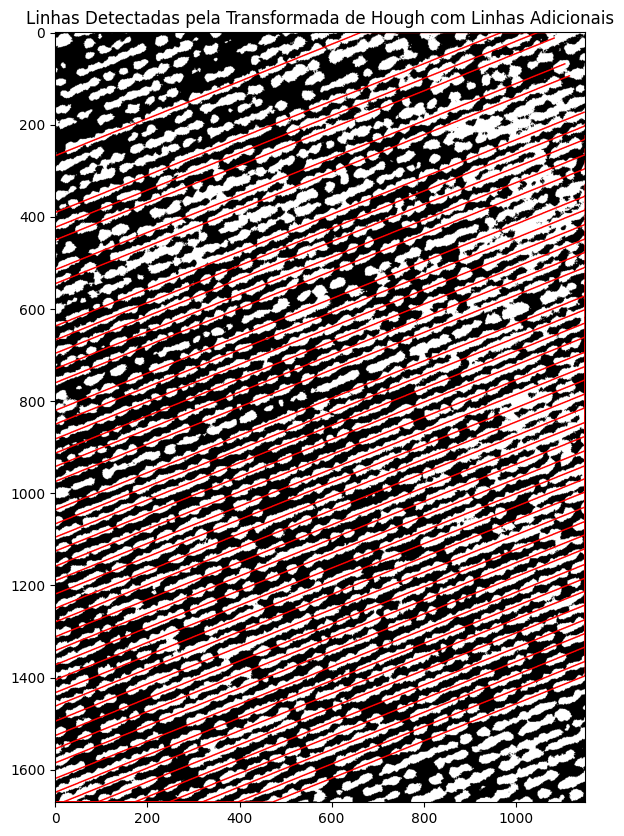

In [ ]:
from skimage.draw import line

# Plotando a imagem original e as linhas detectadas
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap='gray')

# Informações de georreferenciamento (ajuste conforme necessário)
# Supondo que a imagem tem um CRS e transformações conhecidas
pixel_size_x = 0.05 // 4  # Tamanho do pixel em metros no eixo x
pixel_size_y = 0.05 // 4 # Tamanho do pixel em metros no eixo y
origin_x = 0        # Coordenada x do canto superior esquerdo
origin_y = 0        # Coordenada y do canto superior esquerdo

# Preparando os dados para o shapefile
lines = []
for _, angle, dist in zip(*peaks):
    # Calcula os pontos finais das linhas
    x0 = np.cos(angle) * dist
    y0 = np.sin(angle) * dist
    x1 = int(x0 + 1000 * (-np.sin(angle)))
    y1 = int(y0 + 1000 * (np.cos(angle)))
    x2 = int(x0 - 1000 * (-np.sin(angle)))
    y2 = int(y0 - 1000 * (np.cos(angle)))

    # Converter coordenadas da imagem para coordenadas geográficas
    x1_geo = origin_x + x1 * pixel_size_x
    y1_geo = origin_y + y1 * pixel_size_y
    x2_geo = origin_x + x2 * pixel_size_x
    y2_geo = origin_y + y2 * pixel_size_y

    # Adiciona a linha detectada à lista
    lines.append(LineString([(x1_geo, y1_geo), (x2_geo, y2_geo)]))

    # Desenha as linhas na imagem
    rr, cc = line(y1, x1, y2, x2)
    rr = np.clip(rr, 0, image.shape[0] - 1)
    cc = np.clip(cc, 0, image.shape[1] - 1)
    ax.plot(cc, rr, color='red', linewidth=1)

plt.title('Linhas Detectadas pela Transformada de Hough com Linhas Adicionais')
plt.show()

# Criando um GeoDataFrame com as linhas detectadas
gdf = gpd.GeoDataFrame(geometry=lines, crs='EPSG:4326')  # Ajuste o CRS conforme necessário

# Salvando o GeoDataFrame como um shapefile
shapefile_path = '/content/drive/Shareddrives/Inspectral Drive/Projetos/CANA/linhas_detectadas.shp'
gdf.to_file(shapefile_path)